# Section 1.4.2.1
https://www.itl.nist.gov/div898/handbook/eda/section4/eda421.htm

Normal random numbers

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

In [2]:
# set random seed for reproducibility
np.random.seed(123)

In [3]:
# suppress some warnings from pymc3 output
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
%matplotlib inline

The data set has been downloaded from https://www.itl.nist.gov/div898/handbook/datasets/RANDN.DAT

In [5]:
# load data from file as 1d array
filename = 'RANDN.DAT'
data = (np.loadtxt(filename,skiprows=25)).flatten()

In [6]:
n=len(data);
print(n)

500


In [7]:
data[:5] # first five data points

array([-1.276, -1.218, -0.453, -0.35 ,  0.723])

Check some summary statistics to see if they agree.  The published mean in -0.00294 and the published standard deviation is 1.021042.

In [8]:
data.mean()

-0.002936

In [9]:
data.std(ddof=1) # ddof=1 gives sample deviation instead of population deviation (ddof=0).

1.0210411813889704

Reproduce the plots in the source to check for consistency

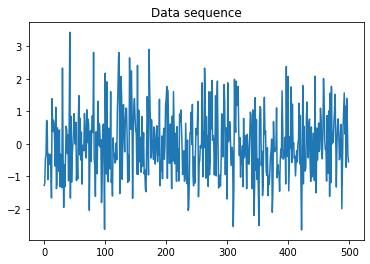

In [10]:
plt.plot(data)
plt.title('Data sequence');

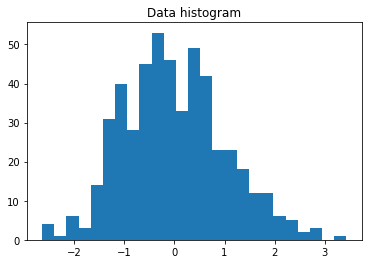

In [11]:
plt.hist(data,bins=25)
plt.title('Data histogram');

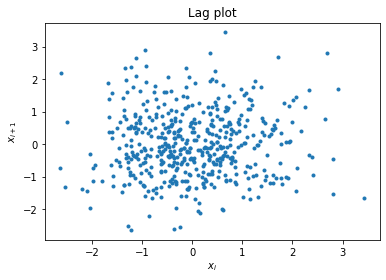

In [12]:
plt.plot(data[:-1],data[1:],'.')
plt.xlabel('$x_i$');
plt.ylabel('$x_{i+1}$')
plt.title('Lag plot');

## Posterior of the mean, assuming fixed variance

Since the data are nominally normally distributed, if we assume a flat prior, analytically we'll get a posterior of
$$
p(\theta|y) \approx N(\theta,\bar{y},\sigma^2/n)
$$
(ref. Gelman pg 52)

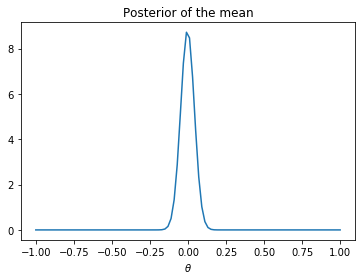

In [13]:
x = np.linspace(-1,1,100)
plt.plot(x,st.norm.pdf(x,data.mean(),np.sqrt(data.std(ddof=1)/n)))
plt.title('Posterior of the mean')
plt.xlabel(r'$ \theta $');

### Model using MCMC

In [14]:
import pymc3 as pm

In [15]:
with pm.Model() as model1:
    theta = pm.Flat('theta')
    sigma = data.std(ddof=1)
    yobs = pm.Normal('yobs',mu=theta,sigma=sigma,observed=data)

In [16]:
model1.name='Unknown mean'

In [17]:
with model1:
    trace1=pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:00<00:00, 4335.86draws/s]


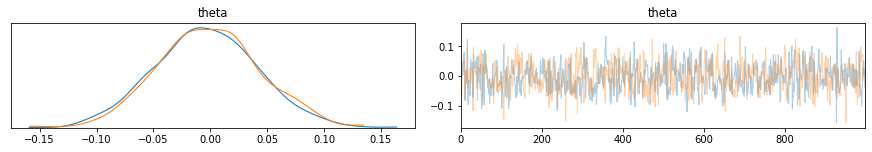

In [18]:
pm.traceplot(trace1);

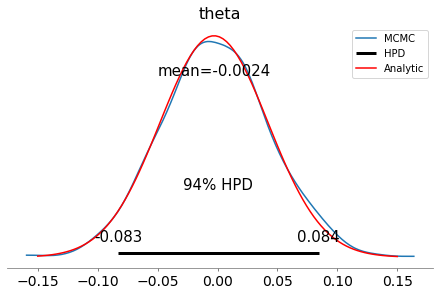

In [19]:
# Compare numerical results to analytic results
pm.plot_posterior(trace1)
x = np.linspace(-0.15,0.15,100)
plt.plot(x,st.norm.pdf(x,data.mean(),np.sqrt(data.std(ddof=1)/n)),'r')
plt.legend(['MCMC','HPD','Analytic']);

### TODOs
* Add linear drift and compare the fixed mean model with linear drift model
* Compare to Gaussian Process model

## Posterior of the variance, assuming fixed mean
For a noninformative prior, the posterior of the variance is
$$
p(\sigma^2|y) = \mathrm{Inv}\chi^2\left(\nu_0+n,\frac{\nu_0\sigma_0^2+n\nu}{\nu_0+n} \right)
= \mathrm{Inv}\Gamma\left(\alpha = \frac12(\nu_0+n),\beta = \frac12(\nu_0+n)\frac{\nu_0\sigma_0^2+nv}{\nu_0+n} \right)
$$
where $$ v = \frac{1}{n}\sum(y_i-\mu)^2 $$

For the noninformative prior, $\nu_0=0$.

In [20]:
mu = data.mean()
v = np.sum((data-mu)**2)/n
alpha = n/2
beta = n/2*v

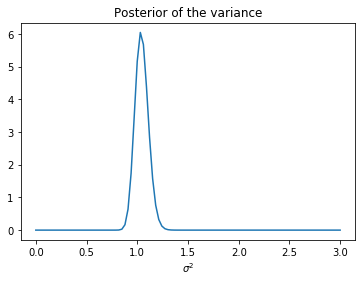

In [21]:
x=np.linspace(0,3,100)
plt.plot(x,st.invgamma.pdf(x,a=alpha,scale=beta))
plt.xlabel('$\sigma^2$')
plt.title('Posterior of the variance');

### Model using MCMC


In [22]:
with pm.Model() as model2:
    logs = pm.Flat('logs')
    s = pm.Deterministic('s',pm.math.exp(logs))
    s2 = pm.Deterministic('s2',s*s)
    yobs = pm.Normal('yobs',mu=data.mean(),sigma=s,observed=data)

In [23]:
model2.name='Unknown sigma'

In [24]:
with model2:
    trace2 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logs]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:00<00:00, 3876.94draws/s]


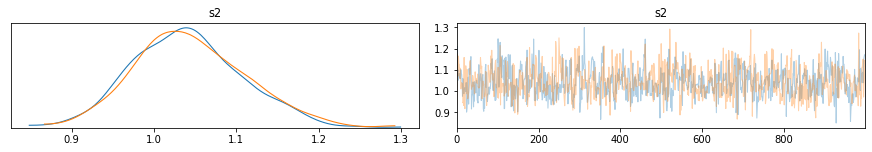

In [25]:
pm.traceplot(trace2,var_names='s2');

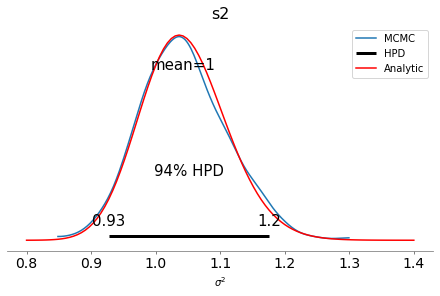

In [26]:
pm.plot_posterior(trace2,var_names='s2')
x=np.linspace(0.8,1.4,100)
plt.plot(x,st.invgamma.pdf(x,a=alpha,scale=beta),'r')
plt.legend(['MCMC','HPD','Analytic'])
plt.xlabel('$\sigma^2$');

## Posterior for unknown mean and unknown variance

The joint posterior for the mean and variance, assuming a noninformative prior, is
$$
p(\mu,\sigma^2|y) = \frac{1}{\sigma^{n+2}} \exp\left(
-\frac{1}{2\sigma^2}\left( (n-1)s^2 + n(\bar{y}-\mu)^2\right)
\right)
$$
where $\bar{y}$ is the sample mean and $s^2$ is the sample variance.

The marginal posterior for the mean and variance are
$$
p(\mu|y) = t_{n-1}(\bar{y},s^2/n)\qquad\textrm{and}\qquad
p(\sigma^2|y) = \mathrm{Inv}\chi^2\left(n-1,s^2 \right)
=\mathrm{Inv}\Gamma\left(\alpha=(n-1)/2 ,\beta=s^2(n-1)/2 \right)
$$

In [27]:
# TODO plot the joint posterior and marginal posteriors

### MCMC

In [28]:
with pm.Model() as model3:
    logs = pm.Flat('logs')
    s = pm.Deterministic('s',pm.math.exp(logs))
    s2 = pm.Deterministic('s2',s*s)
    mu = pm.Flat('mu')
    yobs = pm.Normal('yobs',mu=mu,sigma=s,observed=data)

In [29]:
model3.name='Unknown mean and std'

In [30]:
with model3:
    trace3 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, logs]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:01<00:00, 2962.67draws/s]


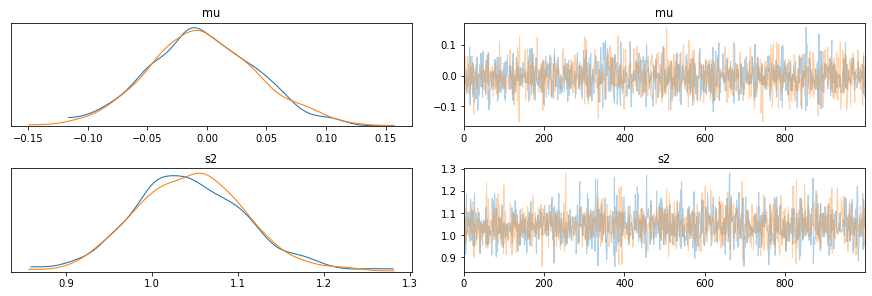

In [31]:
pm.traceplot(trace3,var_names=['mu','s2']);

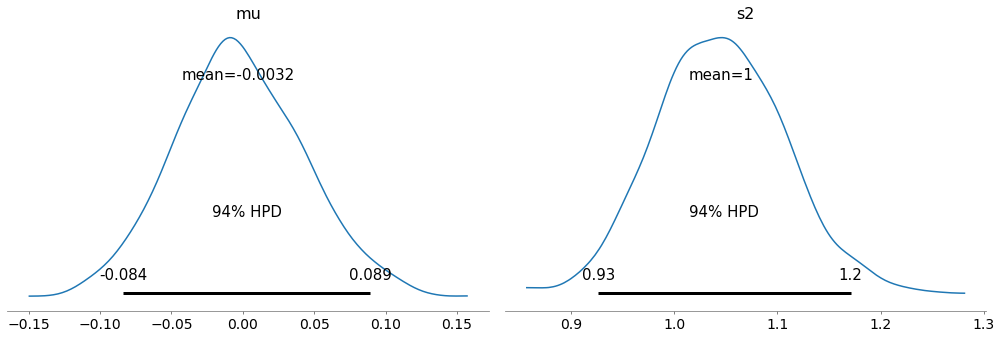

In [32]:
pm.plot_posterior(trace3,var_names=['mu','s2']);

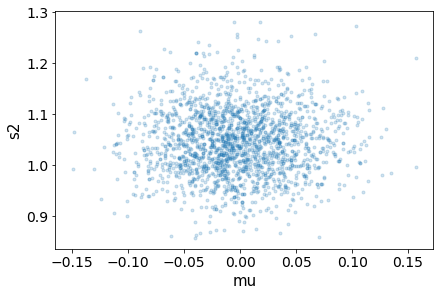

In [33]:
pm.pairplot(trace3,var_names=['mu','s2'],plot_kwargs={'alpha': 0.2});

In [34]:
import corner

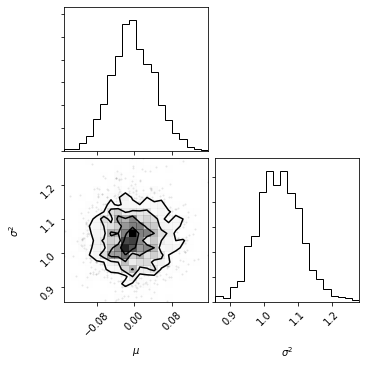

In [35]:
corner.corner(np.vstack((trace3['mu'], trace3['s2'])).T,labels=['$\mu$','$\sigma^2$']);

## Linear drift model
Check to see if the mean depends on time, by fitting a linear model.

In [36]:
x=np.arange(n)

### TODO
Solve this analytically

### MCMC

In [52]:
with pm.Model() as model4:
    a = pm.Flat('a')
    b = pm.Flat('b')
    sigma = data.std(ddof=1)
    mu = pm.Deterministic('mu',a*x+b)
    yobs = pm.Normal('yobs',mu=mu,sigma=sigma,observed=data)

In [53]:
model4.name='Linear drift'

In [54]:
with model4:
    tune=1000
    trace4=pm.sample(1000,tune=tune)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1038.75draws/s]


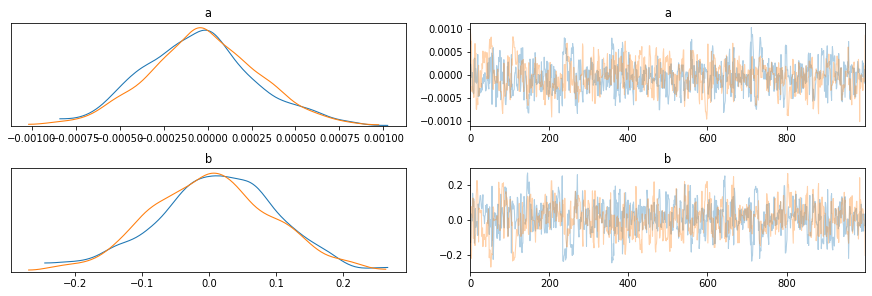

In [55]:
pm.traceplot(trace4,var_names=['a','b']);

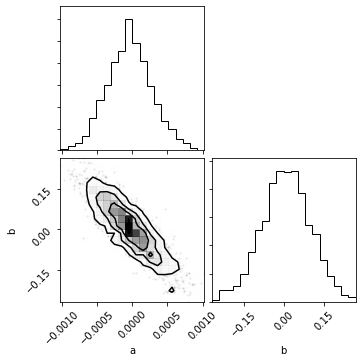

In [56]:
corner.corner(np.vstack((trace4['a'],trace4['b'])).T,labels=['a','b']);

In [57]:
# calculate posterior predictive values of the fit
with model4:
    post4 = pm.sample_posterior_predictive(trace4,500,var_names=['mu'])

100%|██████████| 500/500 [00:00<00:00, 3856.47it/s]


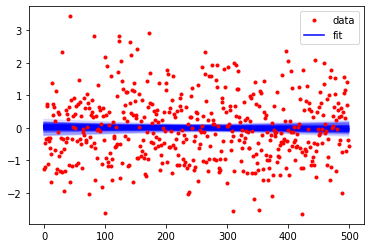

In [71]:
import matplotlib.lines
plt.plot(x,post4['mu'].T,'-b',alpha=0.03)
plt.plot(x,data,'.r');
legfit = matplotlib.lines.Line2D([],[],color='b')
legdata = matplotlib.lines.Line2D([],[],color='r',marker='.',linewidth=0)
plt.legend([legdata,legfit],['data','fit']);

## Model comparison
(I don't understand this yet, but following the recipes in the `pymc3` examples...)

In [64]:
models={model4: trace4, model1: trace1}

In [65]:
pm.compare(models,ic='WAIC')

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
Unknown mean,1440.67,0.95,0,1,31.59,0,0
Linear drift,1442.81,2,2.14,0,31.62,0.26,0


The top entry in the table is the prefered model, including "Occam's razor" factor.